## Практическое занятие "Подготовка данных"

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


## Работа с текстовыми данными

Как правило, модели машинного обучения действуют в предположении, что матрица "объект-признак" является вещественнозначной, поэтому при работе с текстами сперва для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, tf-idf и пр. Рассмотрим их на примере [датасета](https://www.dropbox.com/s/f9xsff8xluriy95/banki_responses.json.bz2?dl=0) отзывов о банках.

Сперва загрузим данные:

In [2]:
data = fetch_20newsgroups(subset='all', categories=['comp.graphics', 'sci.med'])

Данные содержат тексты новостей, которые надо классифицировать на разделы.

In [3]:
data['target_names']

['comp.graphics', 'sci.med']

In [5]:
texts = data['data']
target = data['target']

Например:

In [6]:
texts[0]

'From: dyer@spdcc.com (Steve Dyer)\nSubject: Re: Analgesics with Diuretics\nOrganization: S.P. Dyer Computer Consulting, Cambridge MA\n\nIn article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:\n>I sometimes see OTC preparations for muscle aches/back aches that\n>combine aspirin with a diuretic.\n\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n>The idea seems to be to reduce\n>inflammation by getting rid of fluid. Does this actually work? \n\nThat\'s not the idea, and no, they don\'t work.\n\n-- \nSteve Dyer\ndyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer\n'

In [7]:
data['target_names'][target[0]]

'sci.med'

### Bag-of-words

Самый очевидный способ формирования признакового описания текстов — векторизация. Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(texts)

Результатом является разреженная матрица.

In [9]:
vectorizer.transform(texts[:1])

<1x32548 sparse matrix of type '<class 'numpy.int64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [10]:
print(vectorizer.transform(texts[:1]).indptr)
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[ 0 86]
[ 3905  3983  4143  4345  4665  4701  4712  5074  5176  5198  5242  5619
  5870  6348  6984  7232  7630  8267  8451  8460  8682  8733  8916  9557
 10811 10812 10901 10933 10971 11312 11488 13133 13226 13463 13866 14726
 14806 15682 15805 15952 16147 18002 18031 18373 18740 18781 18790 18936
 20420 21036 21164 21166 21494 21518 21622 21769 21839 21856 23589 23602
 24556 24592 24803 25502 25513 26464 26474 27021 27398 27518 27940 28199
 28286 28687 29187 29189 29264 29300 29500 29837 30702 31915 32005 32052
 32095 32392]
[2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 6 2 1 2 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 1 1 1 2 1 1 1 3 2 1 2 1
 2 3 2 1 3 1 1 2 2 1 1 1]


### TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:

$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D)$.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding='utf8', min_df=1)
_ = vectorizer.fit(texts)

На выходе получаем разреженную матрицу.

In [12]:
vectorizer.transform(texts[:1])

<1x32548 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [13]:
print(vectorizer.transform(texts[:1]).indptr)
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[ 0 86]
[32392 32095 32052 32005 31915 30702 29837 29500 29300 29264 29189 29187
 28687 28286 28199 27940 27518 27398 27021 26474 26464 25513 25502 24803
 24592 24556 23602 23589 21856 21839 21769 21622 21518 21494 21166 21164
 21036 20420 18936 18790 18781 18740 18373 18031 18002 16147 15952 15805
 15682 14806 14726 13866 13463 13226 13133 11488 11312 10971 10933 10901
 10812 10811  9557  8916  8733  8682  8460  8451  8267  7630  7232  6984
  6348  5870  5619  5242  5198  5176  5074  4712  4701  4665  4345  4143
  3983  3905]
[0.02775776 0.030364   0.10357777 0.10097852 0.05551552 0.08913878
 0.0751644  0.05521512 0.02543534 0.07527191 0.05440145 0.04646966
 0.07125018 0.0955189  0.01649287 0.12280349 0.25018259 0.0710195
 0.09802838 0.05646637 0.09712269 0.10057076 0.09482619 0.08113136
 0.04893556 0.09057384 0.23738007 0.11869004 0.18429156 0.12343474
 0.01703927 0.04332515 0.12343474 0.01848065 0.05632337 0.12343474
 0.03769659 0.0854585  0.06358581 0.07172143 0.09057384 0.12343474

Заметим, что оба метода возвращают вектор длины 32548 (размер нашего словаря).

Заметим, что одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи **лемматизации** и **стемминга**.

### Стемминг

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) –  это процесс нахождения основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.

**Примеры стемминга:**

| Word        | Stem           |
| ----------- |:-------------:|
| вагон | вагон |
| вагона | вагон |
| вагоне | вагон |
| вагонов | вагон |
| вагоном | вагон |
| вагоны | вагон |
| важная | важн |
| важнее | важн |
| важнейшие | важн |
| важнейшими | важн |
| важничал | важнича |
| важно | важн |

[Snowball](http://snowball.tartarus.org/) – фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке – списки окончаний для разных чистей речи, разных склонений и т.д. Пример алгоритма для русского языка – [Russian stemming](http://snowballstem.org/algorithms/russian/stemmer.html).

In [14]:
import nltk
stemmer = nltk.stem.snowball.RussianStemmer()

In [15]:
print(stemmer.stem(u'машинное'), stemmer.stem(u'обучение'))

машин обучен


In [16]:
stemmer = nltk.stem.snowball.EnglishStemmer()

def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in tqdm(texts[:1000]):
    stemmed_texts.append(stem_text(t, stemmer))

100%|█████████████████████████████████████| 1000/1000 [00:09<00:00, 108.58it/s]


In [17]:
print(texts[0])

From: dyer@spdcc.com (Steve Dyer)
Subject: Re: Analgesics with Diuretics
Organization: S.P. Dyer Computer Consulting, Cambridge MA

In article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:
>I sometimes see OTC preparations for muscle aches/back aches that
>combine aspirin with a diuretic.

You certainly do not see OTC preparations advertised as such.
The only such ridiculous concoctions are nostrums for premenstrual
syndrome, ostensibly to treat headache and "bloating" simultaneously.
They're worthless.

>The idea seems to be to reduce
>inflammation by getting rid of fluid. Does this actually work? 

That's not the idea, and no, they don't work.

-- 
Steve Dyer
dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer



In [18]:
print(stemmed_texts[0])

from: dyer@spdcc.com (steve dyer) subject: re: analges with diuret organization: s.p. dyer comput consulting, cambridg ma in articl <ofk=lve00wb2avukto@andrew.cmu.edu> lawrenc curcio <lc2b+@andrew.cmu.edu> writes: >i sometim see otc prepar for muscl aches/back ach that >combin aspirin with a diuretic. you certain do not see otc prepar advertis as such. the onli such ridicul concoct are nostrum for premenstru syndrome, ostens to treat headach and "bloating" simultaneously. they'r worthless. >the idea seem to be to reduc >inflamm by get rid of fluid. doe this actual work? that not the idea, and no, they don't work. -- steve dyer dyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dy


Как видим, стеммер работает не очень быстро и запускать его для всей выборки достаточно накладно.

### Лемматизация

[Лемматизация](https://en.wikipedia.org/wiki/Lemmatisation) — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Например, для русского языка есть библиотека pymorphy2.

In [21]:
#pip install pymorphy2

In [22]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [23]:
morph.parse('играющих')[0]

Parse(word='играющих', tag=OpencorporaTag('PRTF,Subx,impf,tran,pres,actv plur,gent'), normal_form='играть', score=0.6, methods_stack=((DictionaryAnalyzer(), 'играющих', 1694, 34),))

Сравним работу стеммера и лемматизатора на примере:

In [24]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem('играющих'))

игра


In [25]:
print(morph.parse('играющих')[0].normal_form)

играть


## Трансформация признаков и целевой переменной

Разберёмся, как может влиять трансформация признаков или целевой переменной на качество модели. 

### Логарифмирование 

Воспользуется датасетом с ценами на дома, с которым мы уже сталкивались ранее ([House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)).

In [26]:
#!wget  -O 'train_sem4.csv' -q 'https://www.dropbox.com/s/syfy4lb6xb7wdlx/_train_sem4.csv?dl=0'

In [27]:
data = pd.read_csv("data/train_sem2.csv")

data = data.drop(columns=["Id"])
y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

Посмотрим на распределение целевой переменной 

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


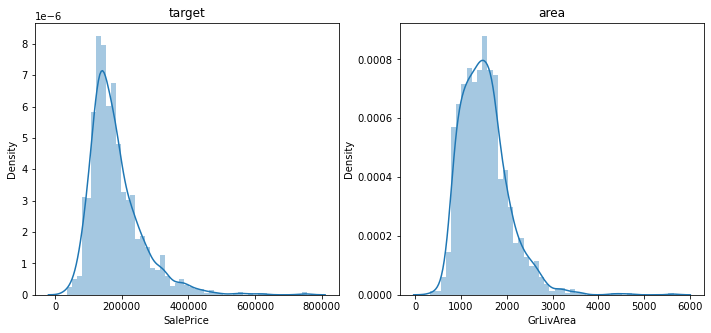

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.distplot(y, label='target')
plt.title('target')

plt.subplot(1, 2, 2)
sns.distplot(data.GrLivArea, label='area')
plt.title('area')
plt.show()

Видим, что распределения несимметричные с тяжёлыми правыми хвостами.

Оставим только числовые признаки, пропуски заменим средним значением.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

Если разбирать линейную регрессия с [вероятностной](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem04-linregr.pdf) точки зрения, то можно получить, что шум должен быть распределён нормально. Поэтому лучше, когда целевая переменная распределена также нормально.

Если прологарифмировать целевую переменную, то её распределение станет больше похоже на нормальное:

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


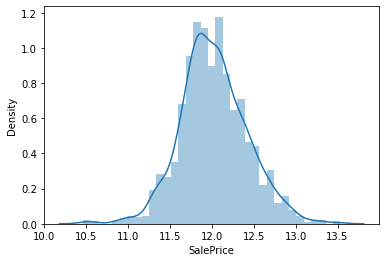

In [30]:
sns.distplot(np.log(y+1), label='target')
plt.show()

Сравним качество линейной регрессии в двух случаях:
1. Целевая переменная без изменений.
2. Целевая переменная прологарифмирована.

Не забудем вернуть во втором случае взять экспоненту от предсказаний!

In [31]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 32085.7681


In [32]:
model = Ridge()
model.fit(X_train, np.log(y_train+1))
y_pred = np.exp(model.predict(X_test))-1

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 26649.2742


Попробуем аналогично логарифмировать один из признаков, имеющих также смещённое распределение (этот признак был вторым по важности!)

In [33]:
X_train.GrLivArea = np.log(X_train.GrLivArea + 1)
X_test.GrLivArea = np.log(X_test.GrLivArea + 1)

In [34]:
model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 31893.8891


In [35]:
model = Ridge()
model.fit(X_train[numeric_features], np.log(y_train+1))
y_pred = np.exp(model.predict(X_test[numeric_features]))-1

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred) ** 0.5)

Test RMSE = 25935.0780


Как видим, преобразование признаков влияет слабее. Признаков много, а вклад размывается по всем. К тому же, проверять распределение множества признаков технически сложнее, чем одной целевой переменной.

### Бинаризация

Мы уже смотрели, как полиномиальные признаки могут помочь при восстановлении нелинейной зависимости линейной моделью. Альтернативный подход заключается в бинаризации признаков. Мы разбиваем ось значений одного из признаков на куски (бины) и добавляем для каждого куска-бина новый признак-индикатор попадения в этот бин.

In [36]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
X = np.random.uniform(0, 1, size=100)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

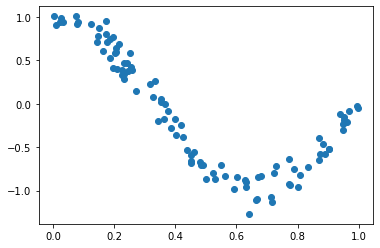

In [37]:
plt.scatter(X, y)

In [38]:
X = X.reshape((-1, 1))
thresholds = np.arange(0.2, 1.1, 0.2).reshape((1, -1))

X_expand = np.hstack((
    X,
    ((X > thresholds[:, :-1]) & (X <= thresholds[:, 1:])).astype(int)))

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [40]:
-np.mean(cross_val_score(
    LinearRegression(), X, y, cv=KFold(n_splits=3),
    scoring='neg_mean_squared_error'))

0.20553980048560802

In [41]:
-np.mean(cross_val_score(
    LinearRegression(), X_expand, y, cv=KFold(n_splits=3),
    scoring='neg_mean_squared_error'))

0.05580385745900118

Так линейная модель может лучше восстанавливать нелинейные зависимости.

## Транзакционные данные

Напоследок посмотрим, как можно извлекать признаки из транзакционных данных. 

Транзакционные данные характеризуются тем, что есть много строк, характеризующихся моментов времени и некоторым числом (суммой денег, например). При этом если это банк, то каждому человеку принадлежит не одна транзакция, а чаще всего надо предсказывать некоторые сущности для клиентов. Таким образом, надо получить признаки для пользователей из множества их транзакций. Этим мы и займёмся.

Для примера возьмём данные [отсюда](https://www.kaggle.com/regivm/retailtransactiondata/). Задача детектирования фродовых клиентов.

In [42]:
# !wget  -O 'Retail_Data_Response.csv' -q 'https://www.dropbox.com/s/le9icl9syo22thh/Retail_Data_Response.csv?dl=0'
# !wget  -O 'Retail_Data_Transactions.csv' -q 'https://www.dropbox.com/s/obsxryxpfsdz3ut/Retail_Data_Transactions.csv?dl=0'

In [43]:
customers = pd.read_csv('data/Retail_Data_Response.csv')
transactions = pd.read_csv('data/Retail_Data_Transactions.csv')

In [44]:
customers.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [45]:
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [46]:
transactions.trans_date = transactions.trans_date.apply(
    lambda x: datetime.datetime.strptime(x, '%d-%b-%y'))

Посмотрим на распределение целевой переменной:

In [47]:
customers.response.mean()

0.09398605461940732

Получаем примерно 1 к 9 положительных примеров. Если такие данные разбивать на части для кросс валидации, то может получиться так, что в одну из частей попадёт слишком мало положительных примеров, а в другую — наоборот. На случай такого неравномерного баланса классов есть StratifiedKFold, который бьёт данные так, чтобы баланс классов во всех частях был одинаковым.

In [48]:
from sklearn.model_selection import StratifiedKFold

Когда строк на каждый объект много, можно считать различные статистики. Например, средние, минимальные и максимальные суммы, потраченные клиентом, количество транзакий, ...

In [49]:
agg_transactions = transactions.groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

data = pd.merge(customers, agg_transactions, how='left', on='customer_id')

data.head()

,customer_id,response,mean,std,count,min,max
0,CS1112,0,67.466667,19.766012,15,36,105
1,CS1113,0,74.500000,21.254102,20,36,98
2,CS1114,1,75.368421,21.341692,19,37,105
3,CS1115,1,75.409091,18.151896,22,41,104
4,CS1116,1,65.923077,22.940000,13,40,105


In [50]:
from sklearn.linear_model import LogisticRegression

np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

D:\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


0.7138460124535347

Но каждая транзакция снабжена датой! Можно посчитать статистики только по свежим транзакциям. Добавим их.

In [51]:
transactions.trans_date.min(), transactions.trans_date.max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

In [52]:
agg_transactions = transactions.loc[transactions.trans_date.apply(
    lambda x: x.year == 2014)].groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

In [53]:
data = pd.merge(data, agg_transactions, how='left', on='customer_id', suffixes=('', '_2014'))
data = data.fillna(0)

In [54]:
np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

0.7492944117908228

Можно также считать дату первой и последней транзакциями пользователей, среднее время между транзакциями и прочее.